In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV , KFold
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.svm import SVR
from sklearn.multioutput import MultiOutputRegressor
from sklearn.preprocessing import StandardScaler

import joblib

# Metricas

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import cross_val_score


In [2]:
df = pd.read_csv('DATOS/Conjunto_Datatraining.csv')
print(df.head())

   id id_siva  AB2_1  AB2_2  AB2_3  AB2_4  AB2_5  AB2_6  AB2_7  AB2_8  ...  \
0   2    row2    2.0    5.0    8.0   10.0   12.0   15.0   18.0   20.0  ...   
1   7    row7    2.0    5.0    8.0   10.0   12.0   15.0   18.0   20.0  ...   
2   8    row8    2.0    5.0    8.0   10.0   12.0   15.0   18.0   20.0  ...   
3  13   row13    2.0    5.0    8.0   10.0   12.0   15.0   18.0   20.0  ...   
4  18   row18    2.0    5.0    8.0   10.0   12.0   15.0   18.0   20.0  ...   

    R_21   R_22   R_23   R_24   R_25   R_26   R_27   R_28   R_29      R_30  
0  100.0  100.0  100.0  100.0  100.0  100.0  100.0  100.0  100.0  5718.072  
1  100.0  100.0  100.0  100.0  100.0  100.0  100.0  100.0  100.0   120.000  
2  804.5  804.5  804.5  804.5  804.5  804.5  804.5  804.5  804.5  5718.072  
3  100.0  100.0  100.0  100.0  100.0  100.0  100.0  100.0  100.0  5718.072  
4  100.0  100.0  100.0  100.0  100.0  100.0  100.0  100.0  100.0   120.000  

[5 rows x 122 columns]


In [3]:
# Copia y columnas
df_ml = df.copy()
ab2_cols = [f"AB2_{i}" for i in range(1, 31)]
rhoa_cols = [f"Rhoa_{i}" for i in range(1, 31)]
indicator_cols = [f"is_observed_{i}" for i in range(1, 31)]
X_cols = ab2_cols + rhoa_cols + indicator_cols
y_cols = rhoa_cols

# Split
df_train, df_test = train_test_split(df_ml, test_size=0.2, random_state=42)
y_train = df_train[y_cols].copy()
y_test = df_test[y_cols].copy()

# Indicadores y enmascaramiento
for df_set in [df_train, df_test]:
    for col in indicator_cols:
        df_set[col] = 1.0

np.random.seed(42)
mask_prob = 0.2
for df_set in [df_train, df_test]:
    for i in range(1, 31):
        col = f"Rhoa_{i}"
        ind_col = f"is_observed_{i}"
        mask = np.random.rand(len(df_set)) < mask_prob
        df_set.loc[mask, col] = 0.0
        df_set.loc[mask, ind_col] = 0.0

X_train = df_train[X_cols]
X_test = df_test[X_cols]



# Random Forest    ----- SELECIONADA

Version 2 de codigo

In [4]:
# Definir parámetros para GridSearchCV
param_grid_rf = {
    "n_estimators": [100, 200],
    "max_depth": [10, 15, 20, 30, None],
    "min_samples_split": [2, 5]
}

# Modelo con GridSearchCV
rf = RandomForestRegressor(random_state=42, n_jobs=-1)
rf_multi = MultiOutputRegressor(GridSearchCV(rf, param_grid_rf, cv=3, scoring="r2", n_jobs=-1))
rf_multi.fit(X_train, y_train)

# Guardar el modelo y columnas
joblib.dump(rf_multi, "random_forest_multioutput_v2.joblib")
joblib.dump(X_cols, "random_forest_feature_columns_v2.joblib")

print("Modelo entrenado con GridSearchCV. Mejores parámetros disponibles en rf_multi.estimators_[0].best_params_.")

Modelo entrenado con GridSearchCV. Mejores parámetros disponibles en rf_multi.estimators_[0].best_params_.


In [5]:
# Predicciones
y_pred = rf_multi.predict(X_test)

# Asegurar que y_test y y_pred sean compatibles
y_test_array = y_test.to_numpy() if hasattr(y_test, 'to_numpy') else y_test
y_pred_array = np.array(y_pred)

# Verificar dimensiones
print(f"Shape y_test: {y_test_array.shape}, Shape y_pred: {y_pred_array.shape}")

# Métricas globales (promedio sobre todas las columnas)
mse_global = mean_squared_error(y_test_array, y_pred_array)
rmse_global = np.sqrt(mse_global)
mae_global = mean_absolute_error(y_test_array, y_pred_array)
r2_global = r2_score(y_test_array, y_pred_array, multioutput='uniform_average')

# MAPE por columna y global
def calculate_mape(y_true, y_pred):
    mape_values = []
    for i in range(y_true.shape[1]):
        mask = y_true[:, i] != 0
        if mask.sum() > 0:
            mape_col = np.mean(np.abs((y_true[mask, i] - y_pred[mask, i]) / y_true[mask, i])) * 100
            mape_values.append(mape_col)
    return np.mean(mape_values) if mape_values else np.nan

mape_global = calculate_mape(y_test_array, y_pred_array)

# Métricas por columna (ejemplo para las primeras 5 columnas)
for i in range(min(5, y_test_array.shape[1])):
    mse_col = mean_squared_error(y_test_array[:, i], y_pred_array[:, i])
    r2_col = r2_score(y_test_array[:, i], y_pred_array[:, i])
    print(f"Columna {i+1} - MSE: {mse_col:.4f}, R²: {r2_col:.4f}")

# Acceder a los mejores parámetros (corrección)
try:
    # Acceder al GridSearchCV interno del primer estimador
    best_params = rf_multi.estimators_[0].best_params_
    print("Mejores parámetros del primer target:", best_params)
except AttributeError:
    print("No se encontraron mejores parámetros. Asegúrate de que el modelo fue entrenado con GridSearchCV.")
    print("Parámetros usados en el RandomForestRegressor:", rf_multi.estimators_[0].get_params())

# Imprimir resultados globales
print(f"Score RF (R² global): {r2_global:.4f}")
print(f"MSE global: {mse_global:.4f}")
print(f"RMSE global: {rmse_global:.4f}")
print(f"MAE global: {mae_global:.4f}")
print(f"MAPE global: {mape_global:.2f}%")

# Análisis de residuos
residuals = y_test_array - y_pred_array
residual_mean = np.mean(residuals)
residual_std = np.std(residuals)
print(f"Residuo medio global: {residual_mean:.4f}")
print(f"Desviación estándar de residuos global: {residual_std:.4f}")


Shape y_test: (328, 30), Shape y_pred: (328, 30)
Columna 1 - MSE: 225.0519, R²: 0.9952
Columna 2 - MSE: 198.9564, R²: 0.9958
Columna 3 - MSE: 407.8908, R²: 0.9916
Columna 4 - MSE: 552.8918, R²: 0.9890
Columna 5 - MSE: 1697.3779, R²: 0.9692
Mejores parámetros del primer target: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 100}
Score RF (R² global): 0.9865
MSE global: 2296.3535
RMSE global: 47.9203
MAE global: 12.3811
MAPE global: 3.92%
Residuo medio global: 9.7690
Desviación estándar de residuos global: 46.9140


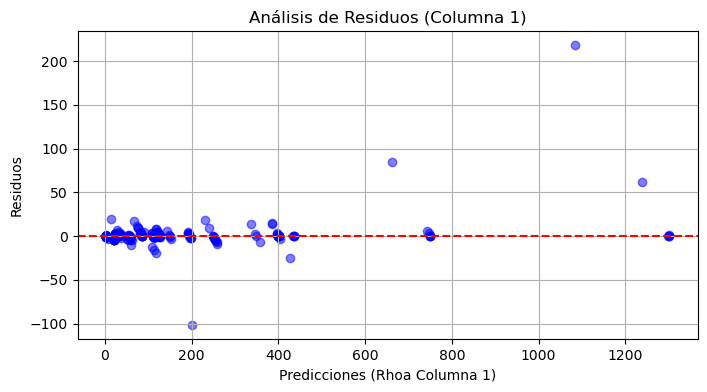

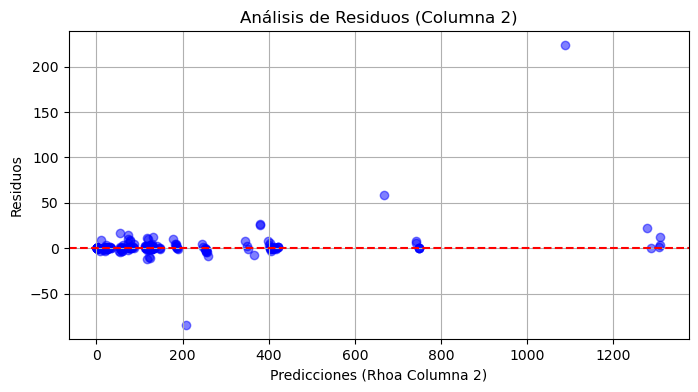

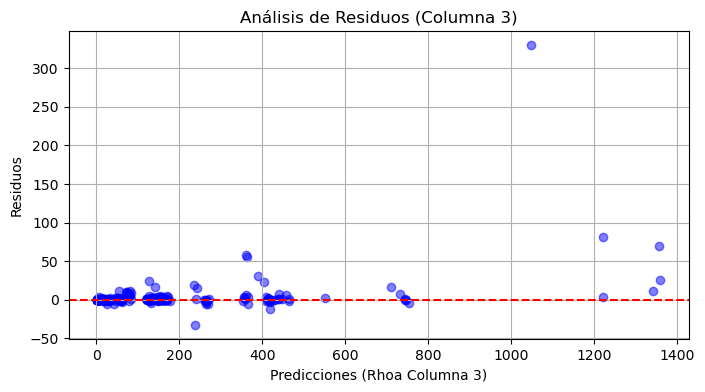

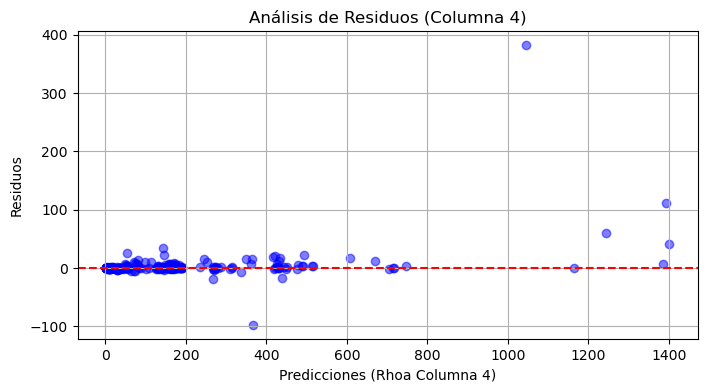

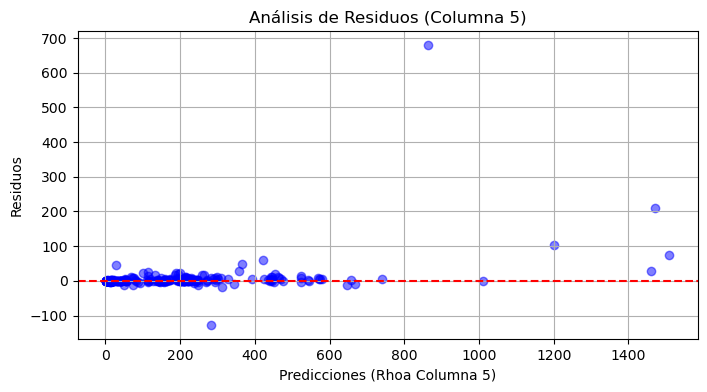

In [6]:
# Generar y guardar gráficos de residuos para las primeras 5 columnas
for i in range(5):
    plt.figure(figsize=(8, 4))
    plt.scatter(y_pred[:, i], residuals[:, i], c='blue', alpha=0.5)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.xlabel(f'Predicciones (Rhoa Columna {i+1})')
    plt.ylabel('Residuos')
    plt.title(f'Análisis de Residuos (Columna {i+1})')
    plt.grid(True)  # Agregar rejilla para mayor claridad
    # Guardar la imagen con un nombre único
    plt.savefig(f'residual_plot_col_{i+1}.png', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()  # Cerrar la figura para liberar memoria

## Métodos Más Rigurosos

Cross-Validation k-Fold: Implementa con cross_val_score de sklearn para obtener R² y MSE promedio:

Learning Curves: Evalúa sesgo y varianza graficando el rendimiento (R²) vs. tamaño del conjunto de entrenamiento para detectar under/overfitting.
Permutation Importance: Mide la importancia de features (e.g., AB2, Rhoa observados) para validar su contribución al modelo.

### Interpretación
Con los valores actuales (ejemplo: R² ~0.94, MSE ~bajo según datos previos), el modelo tiene alta precisión, pero MAPE y residuos ayudarán a identificar errores relativos y patrones. Si R² CV disminuye significativamente, indica posible overfitting. Usa estas métricas para ajustar hiperparámetros (e.g., max_depth, n_estimators) y optimizar el modelo, alineado con prácticas de Statistics Concepts y Groundwater Geophysics.

In [7]:
cv_scores = cross_val_score(rf_multi, X_train, y_train, cv=5, scoring='r2')
print(f"R² CV promedio: {cv_scores.mean():.4f} (±{cv_scores.std() * 2:.4f})")
#R² CV promedio: 0.9852 (±0.0067)

R² CV promedio: 0.9852 (±0.0067)


# Support Vector Machine (SVM) V2

In [6]:
# Definir parámetros para GridSearchCV (adaptado similar a RF)
param_grid_svm = {
    "C": [1, 10, 100],
    "epsilon": [0.1, 0.2, 0.5],
    "kernel": ['rbf', 'linear']
}

# Modelo con GridSearchCV
svm = SVR(max_iter=50000)
svm_multi = MultiOutputRegressor(GridSearchCV(svm, param_grid_svm, cv=3, scoring="r2", n_jobs=8))
svm_multi.fit(X_train, y_train)

# Guardar el modelo y columnas
joblib.dump(svm_multi, "svm_multioutput_v2.joblib")
joblib.dump(X_cols, "svm_feature_columns_v2.joblib")
print("Modelo SVM entrenado con GridSearchCV. Mejores parámetros disponibles en svm_multi.estimators_[0].best_params_.")

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Modelo SVM entrenado con GridSearchCV. Mejores parámetros disponibles en svm_multi.estimators_[0].best_params_.


In [7]:
# Predicciones
y_pred = svm_multi.predict(X_test)

# Asegurar que y_test y y_pred sean compatibles
y_test_array = y_test.to_numpy() if hasattr(y_test, 'to_numpy') else y_test
y_pred_array = np.array(y_pred)

# Verificar dimensiones
print(f"Shape y_test: {y_test_array.shape}, Shape y_pred: {y_pred_array.shape}")

# Métricas globales (promedio sobre todas las columnas)
mse_global = mean_squared_error(y_test_array, y_pred_array)
rmse_global = np.sqrt(mse_global)
mae_global = mean_absolute_error(y_test_array, y_pred_array)
r2_global = r2_score(y_test_array, y_pred_array, multioutput='uniform_average')

# MAPE por columna y global
def calculate_mape(y_true, y_pred):
    mape_values = []
    for i in range(y_true.shape[1]):
        mask = y_true[:, i] != 0
        if mask.sum() > 0:
            mape_col = np.mean(np.abs((y_true[mask, i] - y_pred[mask, i]) / y_true[mask, i])) * 100
            mape_values.append(mape_col)
    return np.mean(mape_values) if mape_values else np.nan

mape_global = calculate_mape(y_test_array, y_pred_array)

# Métricas por columna (ejemplo para las primeras 5 columnas)
for i in range(min(5, y_test_array.shape[1])):
    mse_col = mean_squared_error(y_test_array[:, i], y_pred_array[:, i])
    r2_col = r2_score(y_test_array[:, i], y_pred_array[:, i])
    print(f"Columna {i+1} - MSE: {mse_col:.4f}, R²: {r2_col:.4f}")

# Acceder a los mejores parámetros (corrección)
try:
    # Acceder al GridSearchCV interno del primer estimador
    best_params = svm_multi.estimators_[0].best_params_
    print("Mejores parámetros del primer target:", best_params)
except AttributeError:
    print("No se encontraron mejores parámetros. Asegúrate de que el modelo fue entrenado con GridSearchCV.")
    print("Parámetros usados en el SVR:", svm_multi.estimators_[0].get_params())

# Imprimir resultados globales
print(f"Score SVM (R² global): {r2_global:.4f}")
print(f"MSE global: {mse_global:.4f}")
print(f"RMSE global: {rmse_global:.4f}")
print(f"MAE global: {mae_global:.4f}")
print(f"MAPE global: {mape_global:.2f}%")

Shape y_test: (328, 30), Shape y_pred: (328, 30)
Columna 1 - MSE: 13119.8863, R²: 0.7191
Columna 2 - MSE: 13062.4238, R²: 0.7226
Columna 3 - MSE: 13088.4034, R²: 0.7315
Columna 4 - MSE: 13159.0328, R²: 0.7372
Columna 5 - MSE: 14377.4570, R²: 0.7389
Mejores parámetros del primer target: {'C': 100, 'epsilon': 0.5, 'kernel': 'rbf'}
Score SVM (R² global): 0.8771
MSE global: 14430.5729
RMSE global: 120.1273
MAE global: 41.4465
MAPE global: 94.18%


Residuo medio global: 17.2717
Desviación estándar de residuos global: 118.8792


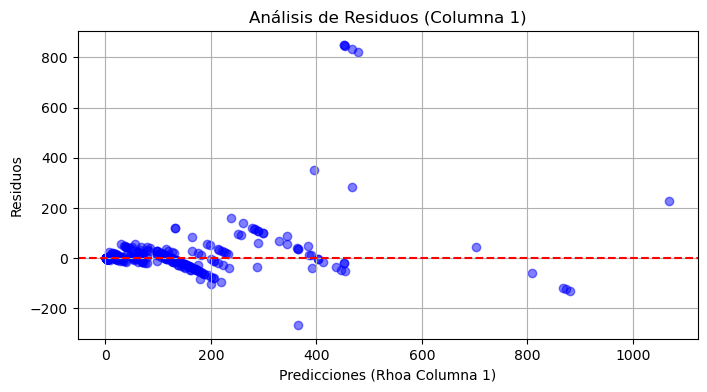

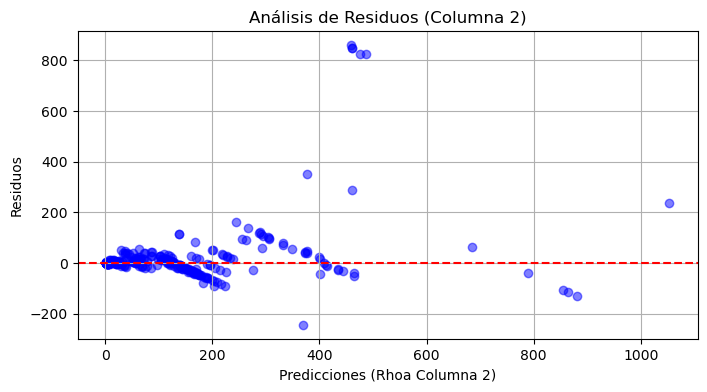

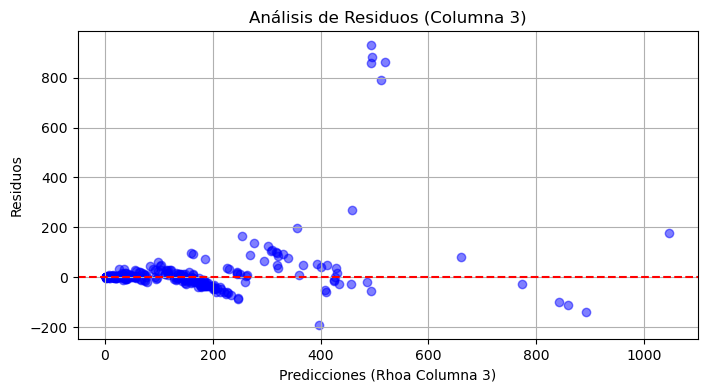

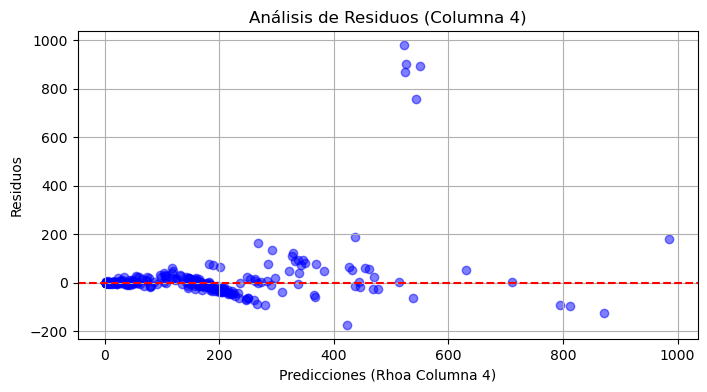

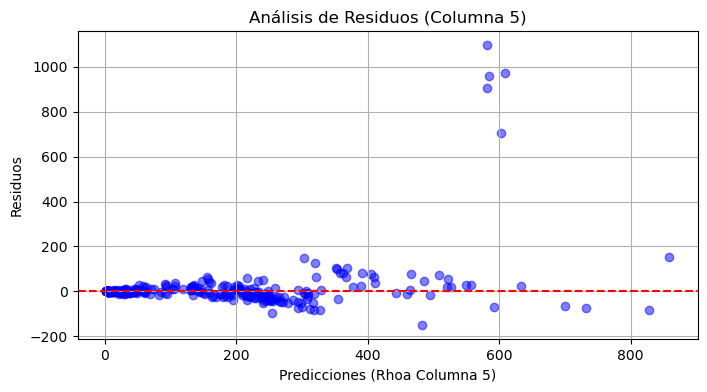

In [8]:
# Análisis de residuos
residuals = y_test_array - y_pred_array
residual_mean = np.mean(residuals)
residual_std = np.std(residuals)
print(f"Residuo medio global: {residual_mean:.4f}")
print(f"Desviación estándar de residuos global: {residual_std:.4f}")

# Generar y guardar gráficos de residuos para las primeras 5 columnas
for i in range(5):
    plt.figure(figsize=(8, 4))
    plt.scatter(y_pred[:, i], residuals[:, i], c='blue', alpha=0.5)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.xlabel(f'Predicciones (Rhoa Columna {i+1})')
    plt.ylabel('Residuos')
    plt.title(f'Análisis de Residuos (Columna {i+1})')
    plt.grid(True)  # Agregar rejilla para mayor claridad
    # Guardar la imagen con un nombre único
    plt.savefig(f'svm_residual_plot_col_{i+1}.png', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()  # Cerrar la figura para liberar memoria

# Support Vector Machine (SVM)

In [8]:
# Definir parámetros para GridSearchCV (corregido)
param_grid_svm = {
    'C': [1, 10, 100],
    'epsilon': [0.1, 0.2, 0.5],
    'kernel': ['rbf', 'linear']
}

# Modelo con GridSearchCV
svm = SVR(max_iter=50000)
svm_multi = MultiOutputRegressor(GridSearchCV(svm, param_grid_svm, cv=3, scoring="r2", n_jobs=8, verbose=2))
svm_multi.fit(X_train, y_train)

# Guardar el modelo y columnas
joblib.dump(svm_multi, "svm_multioutput_v1.joblib")
joblib.dump(X_cols, "svm_feature_columns_v1.joblib")

print("Modelo SVM entrenado con GridSearchCV. Mejores parámetros disponibles en svm_multi.estimators_[0].best_params_.")

Fitting 3 folds for each of 18 candidates, totalling 54 fits
Fitting 3 folds for each of 18 candidates, totalling 54 fits
Fitting 3 folds for each of 18 candidates, totalling 54 fits
Fitting 3 folds for each of 18 candidates, totalling 54 fits
Fitting 3 folds for each of 18 candidates, totalling 54 fits
Fitting 3 folds for each of 18 candidates, totalling 54 fits
Fitting 3 folds for each of 18 candidates, totalling 54 fits
Fitting 3 folds for each of 18 candidates, totalling 54 fits


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Fitting 3 folds for each of 18 candidates, totalling 54 fits
Fitting 3 folds for each of 18 candidates, totalling 54 fits
Fitting 3 folds for each of 18 candidates, totalling 54 fits
Fitting 3 folds for each of 18 candidates, totalling 54 fits
Fitting 3 folds for each of 18 candidates, totalling 54 fits


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Fitting 3 folds for each of 18 candidates, totalling 54 fits
Fitting 3 folds for each of 18 candidates, totalling 54 fits
Fitting 3 folds for each of 18 candidates, totalling 54 fits


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Fitting 3 folds for each of 18 candidates, totalling 54 fits
Fitting 3 folds for each of 18 candidates, totalling 54 fits
Fitting 3 folds for each of 18 candidates, totalling 54 fits
Fitting 3 folds for each of 18 candidates, totalling 54 fits
Fitting 3 folds for each of 18 candidates, totalling 54 fits
Fitting 3 folds for each of 18 candidates, totalling 54 fits
Fitting 3 folds for each of 18 candidates, totalling 54 fits
Fitting 3 folds for each of 18 candidates, totalling 54 fits
Fitting 3 folds for each of 18 candidates, totalling 54 fits
Fitting 3 folds for each of 18 candidates, totalling 54 fits
Fitting 3 folds for each of 18 candidates, totalling 54 fits
Fitting 3 folds for each of 18 candidates, totalling 54 fits
Fitting 3 folds for each of 18 candidates, totalling 54 fits
Fitting 3 folds for each of 18 candidates, totalling 54 fits
Modelo SVM entrenado con GridSearchCV. Mejores parámetros disponibles en svm_multi.estimators_[0].best_params_.


In [9]:

# Predicciones
y_pred = svm_multi.predict(X_test)

# Métricas
y_test_array = y_test.to_numpy()
y_pred_array = np.array(y_pred)
mse_global = mean_squared_error(y_test_array, y_pred_array)
rmse_global = np.sqrt(mse_global)
mae_global = mean_absolute_error(y_test_array, y_pred_array)
r2_global = r2_score(y_test_array, y_pred_array, multioutput='uniform_average')

def calculate_mape(y_true, y_pred):
    mape_values = []
    for i in range(y_true.shape[1]):
        mask = y_true[:, i] != 0
        if mask.sum() > 0:
            mape_col = np.mean(np.abs((y_true[mask, i] - y_pred[mask, i]) / y_true[mask, i])) * 100
            mape_values.append(mape_col)
    return np.mean(mape_values) if mape_values else np.nan

mape_global = calculate_mape(y_test_array, y_pred_array)

for i in range(5):
    mse_col = mean_squared_error(y_test_array[:, i], y_pred_array[:, i])
    r2_col = r2_score(y_test_array[:, i], y_pred_array[:, i])
    print(f"Columna {i+1} - MSE: {mse_col:.4f}, R²: {r2_col:.4f}")

print(f"Score SVM (R² global): {r2_global:.4f}")
print(f"MSE global: {mse_global:.4f}")
print(f"RMSE global: {rmse_global:.4f}")
print(f"MAE global: {mae_global:.4f}")
print(f"MAPE global: {mape_global:.2f}%")



Columna 1 - MSE: 13119.8863, R²: 0.7191
Columna 2 - MSE: 13062.4238, R²: 0.7226
Columna 3 - MSE: 13088.4034, R²: 0.7315
Columna 4 - MSE: 13159.0328, R²: 0.7372
Columna 5 - MSE: 14377.4570, R²: 0.7389
Score SVM (R² global): 0.8771
MSE global: 14430.5729
RMSE global: 120.1273
MAE global: 41.4465
MAPE global: 94.18%


RF
Shape y_test: (328, 30), Shape y_pred: (328, 30)
Columna 1 - MSE: 225.0519, R²: 0.9952
Columna 2 - MSE: 198.9564, R²: 0.9958
Columna 3 - MSE: 407.8908, R²: 0.9916
Columna 4 - MSE: 552.8918, R²: 0.9890
Columna 5 - MSE: 1697.3779, R²: 0.9692
Mejores parámetros del primer target: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 100}
Score RF (R² global): 0.9865
MSE global: 2296.3535
RMSE global: 47.9203
MAE global: 12.3811
MAPE global: 3.92%
Residuo medio global: 9.7690
Desviación estándar de residuos global: 46.9140

--------------------------------------------------

SVM --- max_iter=25000

Columna 1 - MSE: 13119.8863, R²: 0.7191
Columna 2 - MSE: 13062.4238, R²: 0.7226
Columna 3 - MSE: 13088.4034, R²: 0.7315
Columna 4 - MSE: 13159.0328, R²: 0.7372
Columna 5 - MSE: 14377.4570, R²: 0.7389
Score SVM (R² global): 0.8749
MSE global: 15490.7104
RMSE global: 124.4617
MAE global: 44.5462
MAPE global: 121.23%

SVM --- max_iter=50000

Columna 1 - MSE: 13119.8863, R²: 0.7191
Columna 2 - MSE: 13062.4238, R²: 0.7226
Columna 3 - MSE: 13088.4034, R²: 0.7315
Columna 4 - MSE: 13159.0328, R²: 0.7372
Columna 5 - MSE: 14377.4570, R²: 0.7389
Score SVM (R² global): 0.8771
MSE global: 14430.5729
RMSE global: 120.1273
MAE global: 41.4465
MAPE global: 94.18%

SVM --- max_iter=100000

Columna 1 - MSE: 13119.8863, R²: 0.7191
Columna 2 - MSE: 13062.4238, R²: 0.7226
Columna 3 - MSE: 13088.4034, R²: 0.7315
Columna 4 - MSE: 13159.0328, R²: 0.7372
Columna 5 - MSE: 133910.3950, R²: -1.4323
Score SVM (R² global): 0.7845
MSE global: 22175.0023
RMSE global: 148.9127
MAE global: 71.7098
MAPE global: 386.73%


In [10]:
# Validación cruzada
cv_scores = cross_val_score(svm_multi, X_train, y_train, cv=5, scoring='r2')
print(f"R² CV promedio: {cv_scores.mean():.4f} (±{cv_scores.std() * 2:.4f})")

Fitting 3 folds for each of 18 candidates, totalling 54 fits
Fitting 3 folds for each of 18 candidates, totalling 54 fits
Fitting 3 folds for each of 18 candidates, totalling 54 fits
Fitting 3 folds for each of 18 candidates, totalling 54 fits
Fitting 3 folds for each of 18 candidates, totalling 54 fits
Fitting 3 folds for each of 18 candidates, totalling 54 fits
Fitting 3 folds for each of 18 candidates, totalling 54 fits
Fitting 3 folds for each of 18 candidates, totalling 54 fits
Fitting 3 folds for each of 18 candidates, totalling 54 fits
Fitting 3 folds for each of 18 candidates, totalling 54 fits


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Fitting 3 folds for each of 18 candidates, totalling 54 fits


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Fitting 3 folds for each of 18 candidates, totalling 54 fits


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Fitting 3 folds for each of 18 candidates, totalling 54 fits


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Fitting 3 folds for each of 18 candidates, totalling 54 fits


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Fitting 3 folds for each of 18 candidates, totalling 54 fits


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Fitting 3 folds for each of 18 candidates, totalling 54 fits


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Fitting 3 folds for each of 18 candidates, totalling 54 fits


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Fitting 3 folds for each of 18 candidates, totalling 54 fits
Fitting 3 folds for each of 18 candidates, totalling 54 fits
Fitting 3 folds for each of 18 candidates, totalling 54 fits
Fitting 3 folds for each of 18 candidates, totalling 54 fits
Fitting 3 folds for each of 18 candidates, totalling 54 fits
Fitting 3 folds for each of 18 candidates, totalling 54 fits
Fitting 3 folds for each of 18 candidates, totalling 54 fits
Fitting 3 folds for each of 18 candidates, totalling 54 fits
Fitting 3 folds for each of 18 candidates, totalling 54 fits
Fitting 3 folds for each of 18 candidates, totalling 54 fits
Fitting 3 folds for each of 18 candidates, totalling 54 fits
Fitting 3 folds for each of 18 candidates, totalling 54 fits
Fitting 3 folds for each of 18 candidates, totalling 54 fits
Fitting 3 folds for each of 18 candidates, totalling 54 fits
Fitting 3 folds for each of 18 candidates, totalling 54 fits
Fitting 3 folds for each of 18 candidates, totalling 54 fits
Fitting 3 folds for each

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Fitting 3 folds for each of 18 candidates, totalling 54 fits


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Fitting 3 folds for each of 18 candidates, totalling 54 fits


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Fitting 3 folds for each of 18 candidates, totalling 54 fits


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Fitting 3 folds for each of 18 candidates, totalling 54 fits


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Fitting 3 folds for each of 18 candidates, totalling 54 fits


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Fitting 3 folds for each of 18 candidates, totalling 54 fits


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Fitting 3 folds for each of 18 candidates, totalling 54 fits


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Fitting 3 folds for each of 18 candidates, totalling 54 fits


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Fitting 3 folds for each of 18 candidates, totalling 54 fits


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Fitting 3 folds for each of 18 candidates, totalling 54 fits
Fitting 3 folds for each of 18 candidates, totalling 54 fits
Fitting 3 folds for each of 18 candidates, totalling 54 fits
Fitting 3 folds for each of 18 candidates, totalling 54 fits
Fitting 3 folds for each of 18 candidates, totalling 54 fits
Fitting 3 folds for each of 18 candidates, totalling 54 fits
Fitting 3 folds for each of 18 candidates, totalling 54 fits
Fitting 3 folds for each of 18 candidates, totalling 54 fits
Fitting 3 folds for each of 18 candidates, totalling 54 fits
Fitting 3 folds for each of 18 candidates, totalling 54 fits
Fitting 3 folds for each of 18 candidates, totalling 54 fits
Fitting 3 folds for each of 18 candidates, totalling 54 fits
Fitting 3 folds for each of 18 candidates, totalling 54 fits
Fitting 3 folds for each of 18 candidates, totalling 54 fits
Fitting 3 folds for each of 18 candidates, totalling 54 fits
Fitting 3 folds for each of 18 candidates, totalling 54 fits
Fitting 3 folds for each

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Fitting 3 folds for each of 18 candidates, totalling 54 fits


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Fitting 3 folds for each of 18 candidates, totalling 54 fits


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Fitting 3 folds for each of 18 candidates, totalling 54 fits
Fitting 3 folds for each of 18 candidates, totalling 54 fits


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Fitting 3 folds for each of 18 candidates, totalling 54 fits
Fitting 3 folds for each of 18 candidates, totalling 54 fits


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Fitting 3 folds for each of 18 candidates, totalling 54 fits
Fitting 3 folds for each of 18 candidates, totalling 54 fits
Fitting 3 folds for each of 18 candidates, totalling 54 fits
Fitting 3 folds for each of 18 candidates, totalling 54 fits
Fitting 3 folds for each of 18 candidates, totalling 54 fits
Fitting 3 folds for each of 18 candidates, totalling 54 fits
Fitting 3 folds for each of 18 candidates, totalling 54 fits
Fitting 3 folds for each of 18 candidates, totalling 54 fits
Fitting 3 folds for each of 18 candidates, totalling 54 fits
Fitting 3 folds for each of 18 candidates, totalling 54 fits
Fitting 3 folds for each of 18 candidates, totalling 54 fits
Fitting 3 folds for each of 18 candidates, totalling 54 fits
Fitting 3 folds for each of 18 candidates, totalling 54 fits
Fitting 3 folds for each of 18 candidates, totalling 54 fits
Fitting 3 folds for each of 18 candidates, totalling 54 fits
Fitting 3 folds for each of 18 candidates, totalling 54 fits
Fitting 3 folds for each

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Fitting 3 folds for each of 18 candidates, totalling 54 fits


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Fitting 3 folds for each of 18 candidates, totalling 54 fits


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Fitting 3 folds for each of 18 candidates, totalling 54 fits


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Fitting 3 folds for each of 18 candidates, totalling 54 fits
Fitting 3 folds for each of 18 candidates, totalling 54 fits


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Fitting 3 folds for each of 18 candidates, totalling 54 fits


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Fitting 3 folds for each of 18 candidates, totalling 54 fits


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Fitting 3 folds for each of 18 candidates, totalling 54 fits
Fitting 3 folds for each of 18 candidates, totalling 54 fits
Fitting 3 folds for each of 18 candidates, totalling 54 fits


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Fitting 3 folds for each of 18 candidates, totalling 54 fits
Fitting 3 folds for each of 18 candidates, totalling 54 fits
Fitting 3 folds for each of 18 candidates, totalling 54 fits
Fitting 3 folds for each of 18 candidates, totalling 54 fits
Fitting 3 folds for each of 18 candidates, totalling 54 fits
Fitting 3 folds for each of 18 candidates, totalling 54 fits
Fitting 3 folds for each of 18 candidates, totalling 54 fits
Fitting 3 folds for each of 18 candidates, totalling 54 fits
Fitting 3 folds for each of 18 candidates, totalling 54 fits
Fitting 3 folds for each of 18 candidates, totalling 54 fits
Fitting 3 folds for each of 18 candidates, totalling 54 fits
Fitting 3 folds for each of 18 candidates, totalling 54 fits
Fitting 3 folds for each of 18 candidates, totalling 54 fits
Fitting 3 folds for each of 18 candidates, totalling 54 fits
Fitting 3 folds for each of 18 candidates, totalling 54 fits
Fitting 3 folds for each of 18 candidates, totalling 54 fits
Fitting 3 folds for each

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Fitting 3 folds for each of 18 candidates, totalling 54 fits


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Fitting 3 folds for each of 18 candidates, totalling 54 fits


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Fitting 3 folds for each of 18 candidates, totalling 54 fits
Fitting 3 folds for each of 18 candidates, totalling 54 fits


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Fitting 3 folds for each of 18 candidates, totalling 54 fits
Fitting 3 folds for each of 18 candidates, totalling 54 fits


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Fitting 3 folds for each of 18 candidates, totalling 54 fits


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Fitting 3 folds for each of 18 candidates, totalling 54 fits
Fitting 3 folds for each of 18 candidates, totalling 54 fits
Fitting 3 folds for each of 18 candidates, totalling 54 fits


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Fitting 3 folds for each of 18 candidates, totalling 54 fits
Fitting 3 folds for each of 18 candidates, totalling 54 fits
Fitting 3 folds for each of 18 candidates, totalling 54 fits
Fitting 3 folds for each of 18 candidates, totalling 54 fits
Fitting 3 folds for each of 18 candidates, totalling 54 fits
Fitting 3 folds for each of 18 candidates, totalling 54 fits
Fitting 3 folds for each of 18 candidates, totalling 54 fits
Fitting 3 folds for each of 18 candidates, totalling 54 fits
Fitting 3 folds for each of 18 candidates, totalling 54 fits
Fitting 3 folds for each of 18 candidates, totalling 54 fits
Fitting 3 folds for each of 18 candidates, totalling 54 fits
Fitting 3 folds for each of 18 candidates, totalling 54 fits
R² CV promedio: 0.8722 (±0.0236)


FR = R² CV promedio: 0.9852 (±0.0067)
SVM = R² CV promedio: 0.8594 (±0.0568) --- max_iter=25000
      R² CV promedio: 0.8722 (±0.0236) --- max_iter=50000
      R² CV promedio: 0.8049 (±0.1340) --- max_iter=100000

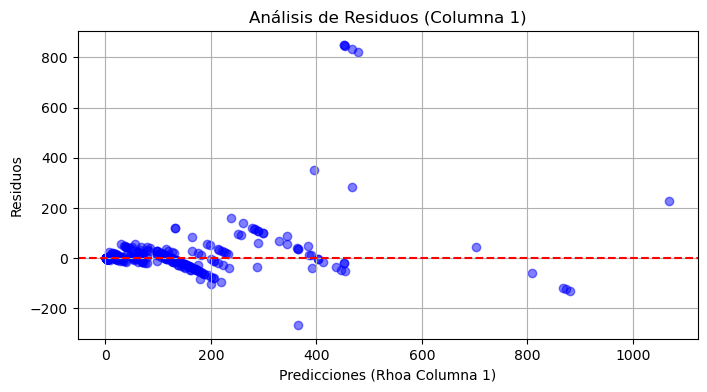

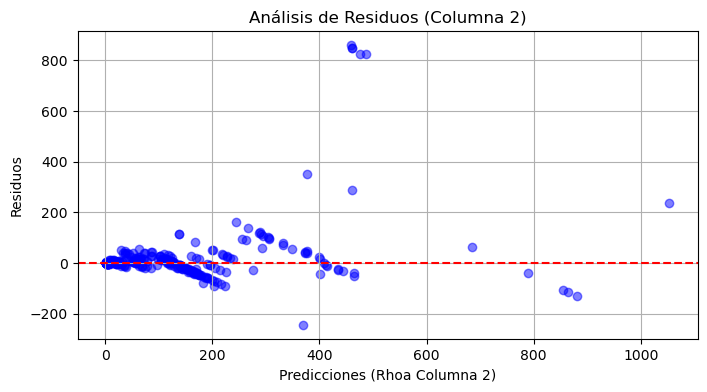

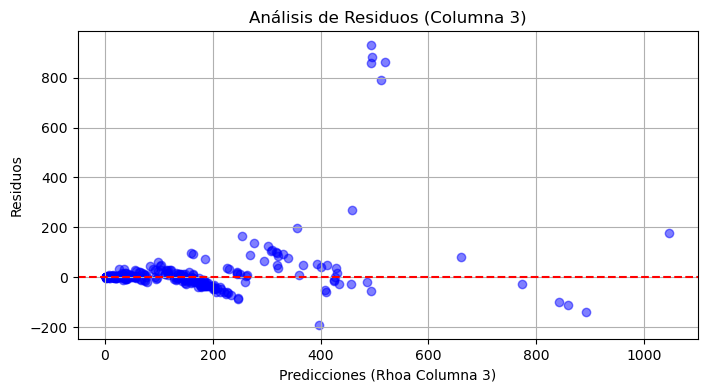

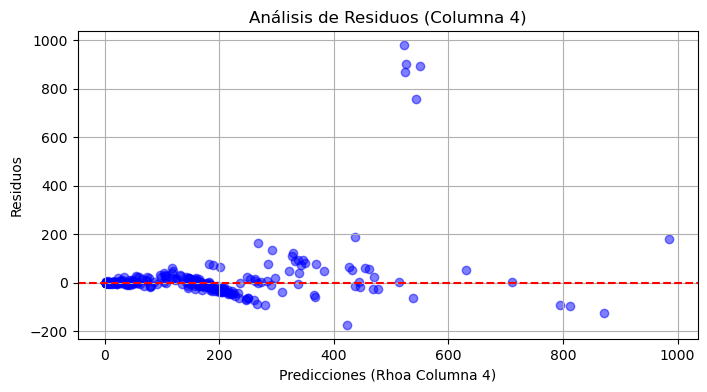

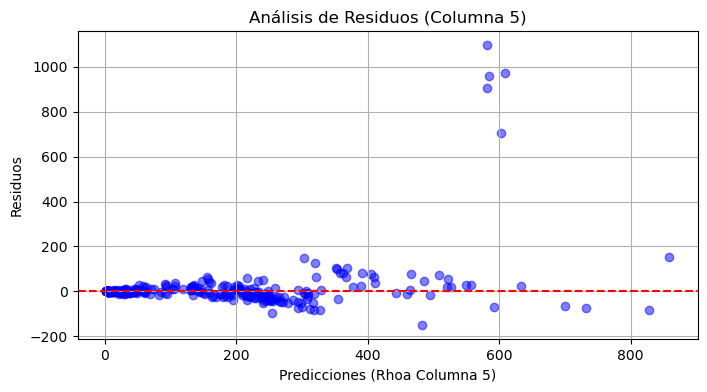

In [11]:
# Gráficos de residuos
residuals = y_test_array - y_pred_array
for i in range(5):
    plt.figure(figsize=(8, 4))
    plt.scatter(y_pred_array[:, i], residuals[:, i], c='blue', alpha=0.5)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.xlabel(f'Predicciones (Rhoa Columna {i+1})')
    plt.ylabel('Residuos')
    plt.title(f'Análisis de Residuos (Columna {i+1})')
    plt.grid(True)
    plt.savefig(f'svm_residual_plot_col_{i+1}.png', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

# Gradient Boosting Regressor (GBR) V2    ------- SELECCIONADA

In [9]:
# Definir parámetros para GridSearchCV (adaptado similar a SVM)
param_grid_gbr = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 5]
}

# Modelo con GridSearchCV
gbr = GradientBoostingRegressor(random_state=42)
gbr_multi = MultiOutputRegressor(GridSearchCV(gbr, param_grid_gbr, cv=3, scoring="r2", n_jobs=8, verbose=2))
gbr_multi.fit(X_train, y_train)

# Guardar el modelo y columnas
joblib.dump(gbr_multi, "gbr_multioutput_v2.joblib")
joblib.dump(X_cols, "gbr_feature_columns_v2.joblib")
print("Modelo GBR entrenado con GridSearchCV. Mejores parámetros disponibles en gbr_multi.estimators_[0].best_params_.")

Fitting 3 folds for each of 8 candidates, totalling 24 fits
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Fitting 3 folds for each of 8 candidates

In [11]:
from scipy.stats import skew, kurtosis, shapiro

Shape y_test: (328, 30), Shape y_pred: (328, 30)
Columna 1 - MSE: 94.3834, R²: 0.9980
Columna 2 - MSE: 358.9965, R²: 0.9924
Columna 3 - MSE: 475.4980, R²: 0.9902
Columna 4 - MSE: 358.6226, R²: 0.9928
Columna 5 - MSE: 593.6401, R²: 0.9892
Mejores parámetros del primer target: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}
Score GBR (R² global): 0.9880
MSE global: 2356.5881
RMSE global: 48.5447
MAE global: 15.7448
MAPE global: 10.65%
Columna 1 - Residuo Media: -0.0412, Std: 9.7150, Asimetría: 1.1980, Curtosis: 29.8844, Shapiro-Wilk p-value: 0.0000
Columna 2 - Residuo Media: 0.4240, Std: 18.9425, Asimetría: -1.2735, Curtosis: 39.7488, Shapiro-Wilk p-value: 0.0000
Columna 3 - Residuo Media: 1.1220, Std: 21.7770, Asimetría: 2.7484, Curtosis: 100.2527, Shapiro-Wilk p-value: 0.0000
Columna 4 - Residuo Media: 0.6758, Std: 18.9253, Asimetría: 3.5056, Curtosis: 67.5842, Shapiro-Wilk p-value: 0.0000
Columna 5 - Residuo Media: 1.8513, Std: 24.2943, Asimetría: 6.8176, Curtosis: 85.2274

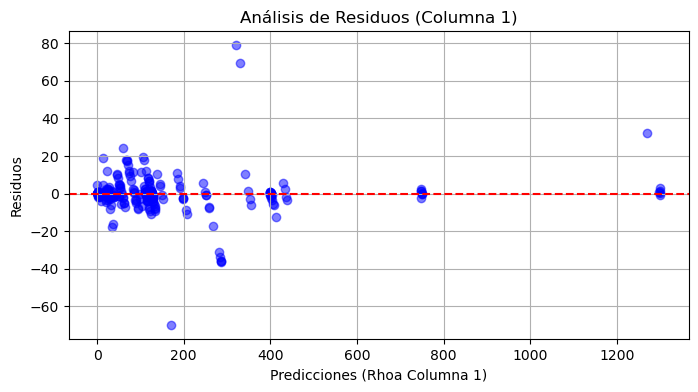

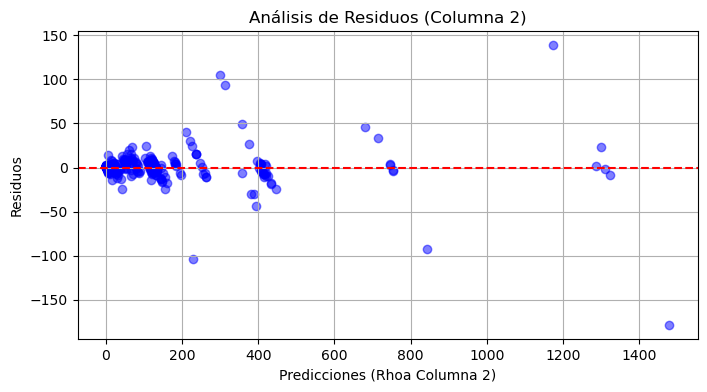

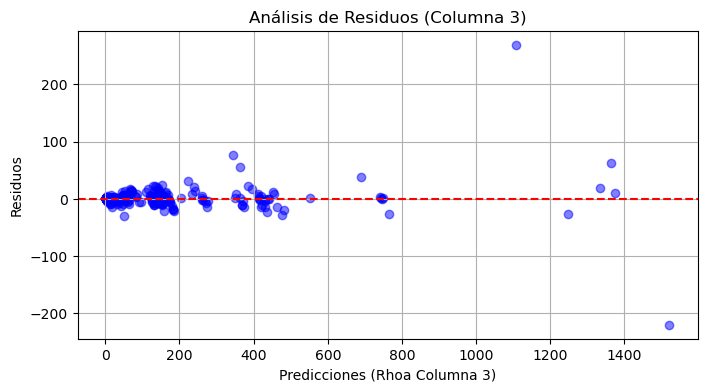

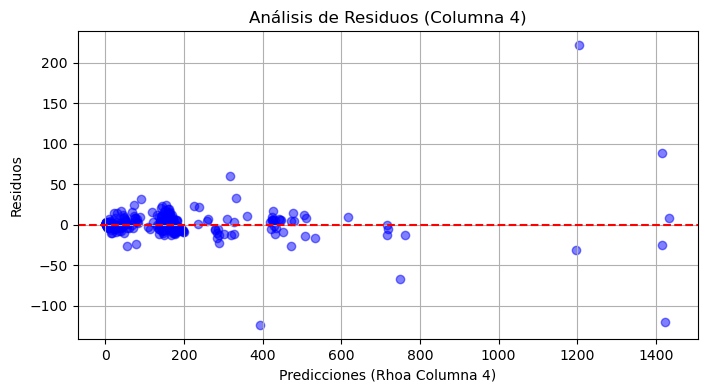

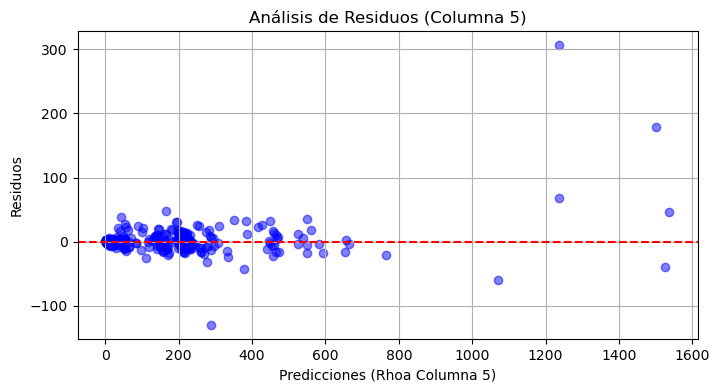

In [12]:
# Predicciones
y_pred = gbr_multi.predict(X_test)

# Asegurar que y_test y y_pred sean compatibles
y_test_array = y_test.to_numpy() if hasattr(y_test, 'to_numpy') else y_test
y_pred_array = np.array(y_pred)

# Verificar dimensiones
print(f"Shape y_test: {y_test_array.shape}, Shape y_pred: {y_pred_array.shape}")

# Métricas globales (promedio sobre todas las columnas)
mse_global = mean_squared_error(y_test_array, y_pred_array)
rmse_global = np.sqrt(mse_global)
mae_global = mean_absolute_error(y_test_array, y_pred_array)
r2_global = r2_score(y_test_array, y_pred_array, multioutput='uniform_average')

# MAPE por columna y global
def calculate_mape(y_true, y_pred):
    mape_values = []
    for i in range(y_true.shape[1]):
        mask = y_true[:, i] != 0
        if mask.sum() > 0:
            mape_col = np.mean(np.abs((y_true[mask, i] - y_pred[mask, i]) / y_true[mask, i])) * 100
            mape_values.append(mape_col)
    return np.mean(mape_values) if mape_values else np.nan

mape_global = calculate_mape(y_test_array, y_pred_array)

# Métricas por columna (ejemplo para las primeras 5 columnas)
for i in range(min(5, y_test_array.shape[1])):
    mse_col = mean_squared_error(y_test_array[:, i], y_pred_array[:, i])
    r2_col = r2_score(y_test_array[:, i], y_pred_array[:, i])
    print(f"Columna {i+1} - MSE: {mse_col:.4f}, R²: {r2_col:.4f}")

# Acceder a los mejores parámetros (corrección)
try:
    # Acceder al GridSearchCV interno del primer estimador
    best_params = gbr_multi.estimators_[0].best_params_
    print("Mejores parámetros del primer target:", best_params)
except AttributeError:
    print("No se encontraron mejores parámetros. Asegúrate de que el modelo fue entrenado con GridSearchCV.")
    print("Parámetros usados en el GradientBoostingRegressor:", gbr_multi.estimators_[0].get_params())

# Imprimir resultados globales
print(f"Score GBR (R² global): {r2_global:.4f}")
print(f"MSE global: {mse_global:.4f}")
print(f"RMSE global: {rmse_global:.4f}")
print(f"MAE global: {mae_global:.4f}")
print(f"MAPE global: {mape_global:.2f}%")

# Análisis estadístico de residuos (adaptado del libro: distribuciones y pruebas)
residuals = y_test_array - y_pred_array
for i in range(5):
    res_col = residuals[:, i]
    mean_res = np.mean(res_col)
    std_res = np.std(res_col)
    skew_res = skew(res_col)
    kurt_res = kurtosis(res_col)
    stat, p_value = shapiro(res_col[~np.isnan(res_col)])  # Prueba de normalidad
    print(f"Columna {i+1} - Residuo Media: {mean_res:.4f}, Std: {std_res:.4f}, Asimetría: {skew_res:.4f}, Curtosis: {kurt_res:.4f}, Shapiro-Wilk p-value: {p_value:.4f}")

# Gráficos de residuos
for i in range(5):
    plt.figure(figsize=(8, 4))
    plt.scatter(y_pred_array[:, i], residuals[:, i], c='blue', alpha=0.5)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.xlabel(f'Predicciones (Rhoa Columna {i+1})')
    plt.ylabel('Residuos')
    plt.title(f'Análisis de Residuos (Columna {i+1})')
    plt.grid(True)
    plt.savefig(f'gbr_residual_plot_col_{i+1}.png', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

# Gradient Boosting Regressor (GBR)

In [12]:
# Definir parámetros para GridSearchCV
param_grid_gbr = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 5]
}

# Modelo con GridSearchCV
gbr = GradientBoostingRegressor(random_state=42)
gbr_multi = MultiOutputRegressor(GridSearchCV(gbr, param_grid_gbr, cv=3, scoring="r2", n_jobs=8, verbose=2))
gbr_multi.fit(X_train, y_train)

# Guardar el modelo y columnas
joblib.dump(gbr_multi, "gbr_multioutput_v1.joblib")
joblib.dump(X_cols, "gbr_feature_columns_v1.joblib")

print("Modelo GBR entrenado con GridSearchCV. Mejores parámetros disponibles en gbr_multi.estimators_[0].best_params_.")

Fitting 3 folds for each of 8 candidates, totalling 24 fits
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Fitting 3 folds for each of 8 candidates

Columna 1 - MSE: 94.3834, R²: 0.9980
Columna 2 - MSE: 358.9965, R²: 0.9924
Columna 3 - MSE: 475.4980, R²: 0.9902
Columna 4 - MSE: 358.6226, R²: 0.9928
Columna 5 - MSE: 593.6401, R²: 0.9892
Score GBR (R² global): 0.9880
MSE global: 2356.5881
RMSE global: 48.5447
MAE global: 15.7448
MAPE global: 10.65%
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Fitting 3 folds for each of 8 candidat

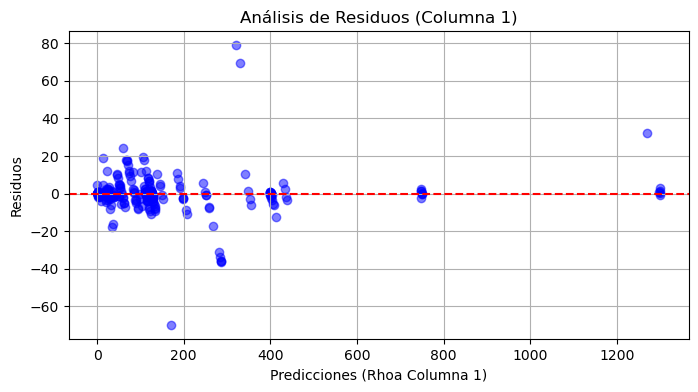

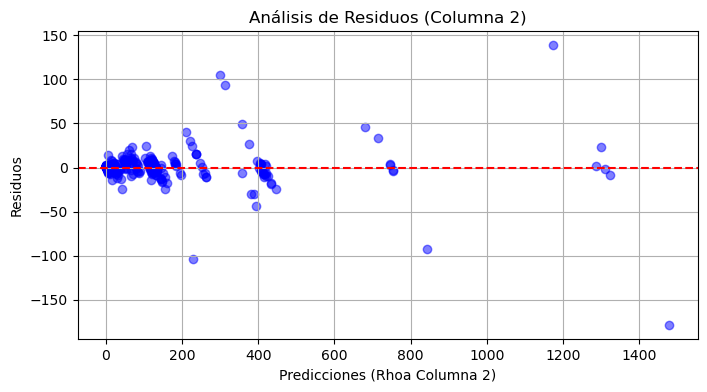

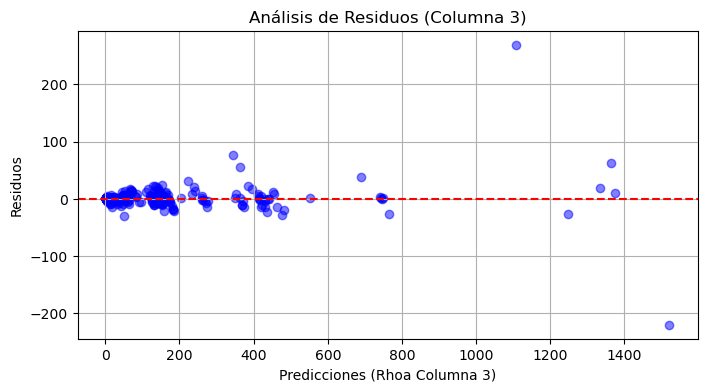

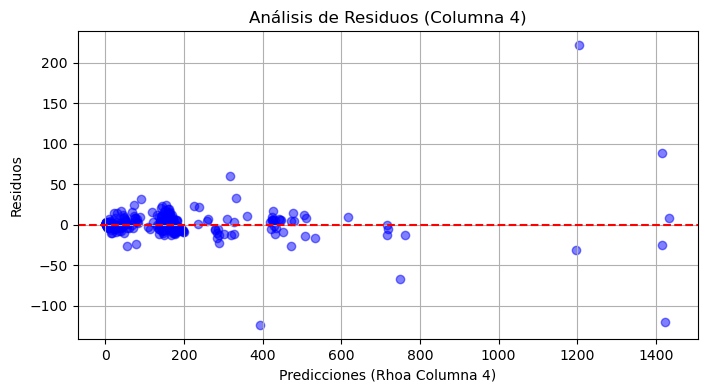

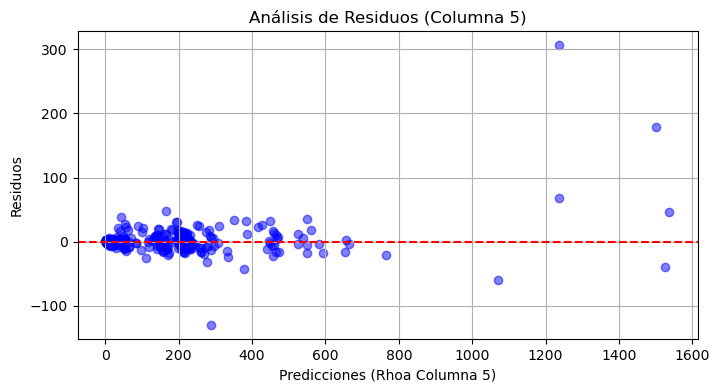

In [13]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from scipy.stats import skew, kurtosis, shapiro
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score

# Cargar el modelo
gbr_multi = joblib.load("gbr_multioutput_v1.joblib")

# Predicciones
y_pred = gbr_multi.predict(X_test)

# Métricas
y_test_array = y_test.to_numpy()
y_pred_array = np.array(y_pred)
mse_global = mean_squared_error(y_test_array, y_pred_array)
rmse_global = np.sqrt(mse_global)
mae_global = mean_absolute_error(y_test_array, y_pred_array)
r2_global = r2_score(y_test_array, y_pred_array, multioutput='uniform_average')

def calculate_mape(y_true, y_pred):
    mape_values = []
    for i in range(y_true.shape[1]):
        mask = y_true[:, i] != 0
        if mask.sum() > 0:
            mape_col = np.mean(np.abs((y_true[mask, i] - y_pred[mask, i]) / y_true[mask, i])) * 100
            mape_values.append(mape_col)
    return np.mean(mape_values) if mape_values else np.nan

mape_global = calculate_mape(y_test_array, y_pred_array)

for i in range(5):
    mse_col = mean_squared_error(y_test_array[:, i], y_pred_array[:, i])
    r2_col = r2_score(y_test_array[:, i], y_pred_array[:, i])
    print(f"Columna {i+1} - MSE: {mse_col:.4f}, R²: {r2_col:.4f}")

print(f"Score GBR (R² global): {r2_global:.4f}")
print(f"MSE global: {mse_global:.4f}")
print(f"RMSE global: {rmse_global:.4f}")
print(f"MAE global: {mae_global:.4f}")
print(f"MAPE global: {mape_global:.2f}%")

# Validación cruzada
cv_scores = cross_val_score(gbr_multi, X_train, y_train, cv=5, scoring='r2')
print(f"R² CV promedio: {cv_scores.mean():.4f} (±{cv_scores.std() * 2:.4f})")

# Análisis estadístico de residuos (adaptado del libro: distribuciones y pruebas)
residuals = y_test_array - y_pred_array
for i in range(5):
    res_col = residuals[:, i]
    mean_res = np.mean(res_col)
    std_res = np.std(res_col)
    skew_res = skew(res_col)
    kurt_res = kurtosis(res_col)
    stat, p_value = shapiro(res_col[~np.isnan(res_col)])  # Prueba de normalidad
    print(f"Columna {i+1} - Residuo Media: {mean_res:.4f}, Std: {std_res:.4f}, Asimetría: {skew_res:.4f}, Curtosis: {kurt_res:.4f}, Shapiro-Wilk p-value: {p_value:.4f}")

# Gráficos de residuos
for i in range(5):
    plt.figure(figsize=(8, 4))
    plt.scatter(y_pred_array[:, i], residuals[:, i], c='blue', alpha=0.5)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.xlabel(f'Predicciones (Rhoa Columna {i+1})')
    plt.ylabel('Residuos')
    plt.title(f'Análisis de Residuos (Columna {i+1})')
    plt.grid(True)
    plt.savefig(f'gbr_residual_plot_col_{i+1}.png', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

GRB

Columna 1 - MSE: 94.3834, R²: 0.9980
Columna 2 - MSE: 358.9965, R²: 0.9924
Columna 3 - MSE: 475.4980, R²: 0.9902
Columna 4 - MSE: 358.6226, R²: 0.9928
Columna 5 - MSE: 593.6401, R²: 0.9892
Score GBR (R² global): 0.9880
MSE global: 2356.5881
RMSE global: 48.5447
MAE global: 15.7448
MAPE global: 10.65%

GRB v2   ------------  SELECCIONADA

Shape y_test: (328, 30), Shape y_pred: (328, 30)
Columna 1 - MSE: 94.3834, R²: 0.9980
Columna 2 - MSE: 358.9965, R²: 0.9924
Columna 3 - MSE: 475.4980, R²: 0.9902
Columna 4 - MSE: 358.6226, R²: 0.9928
Columna 5 - MSE: 593.6401, R²: 0.9892
Mejores parámetros del primer target: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}
Score GBR (R² global): 0.9880
MSE global: 2356.5881
RMSE global: 48.5447
MAE global: 15.7448
MAPE global: 10.65%

---------------------------------------------------

RF ----- SELECCIONADA
Shape y_test: (328, 30), Shape y_pred: (328, 30)
Columna 1 - MSE: 225.0519, R²: 0.9952
Columna 2 - MSE: 198.9564, R²: 0.9958
Columna 3 - MSE: 407.8908, R²: 0.9916
Columna 4 - MSE: 552.8918, R²: 0.9890
Columna 5 - MSE: 1697.3779, R²: 0.9692
Mejores parámetros del primer target: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 100}
Score RF (R² global): 0.9865
MSE global: 2296.3535
RMSE global: 47.9203
MAE global: 12.3811
MAPE global: 3.92%
Residuo medio global: 9.7690
Desviación estándar de residuos global: 46.9140

--------------------------------------------------

SVM --- max_iter=25000

Columna 1 - MSE: 13119.8863, R²: 0.7191
Columna 2 - MSE: 13062.4238, R²: 0.7226
Columna 3 - MSE: 13088.4034, R²: 0.7315
Columna 4 - MSE: 13159.0328, R²: 0.7372
Columna 5 - MSE: 14377.4570, R²: 0.7389
Score SVM (R² global): 0.8749
MSE global: 15490.7104
RMSE global: 124.4617
MAE global: 44.5462
MAPE global: 121.23%

SVM --- max_iter=50000

Columna 1 - MSE: 13119.8863, R²: 0.7191
Columna 2 - MSE: 13062.4238, R²: 0.7226
Columna 3 - MSE: 13088.4034, R²: 0.7315
Columna 4 - MSE: 13159.0328, R²: 0.7372
Columna 5 - MSE: 14377.4570, R²: 0.7389
Score SVM (R² global): 0.8771
MSE global: 14430.5729
RMSE global: 120.1273
MAE global: 41.4465
MAPE global: 94.18%

SVM --- max_iter=100000

Columna 1 - MSE: 13119.8863, R²: 0.7191
Columna 2 - MSE: 13062.4238, R²: 0.7226
Columna 3 - MSE: 13088.4034, R²: 0.7315
Columna 4 - MSE: 13159.0328, R²: 0.7372
Columna 5 - MSE: 133910.3950, R²: -1.4323
Score SVM (R² global): 0.7845
MSE global: 22175.0023
RMSE global: 148.9127
MAE global: 71.7098
MAPE global: 386.73%


SVM v2-- SELECCIONADA

Shape y_test: (328, 30), Shape y_pred: (328, 30)
Columna 1 - MSE: 13119.8863, R²: 0.7191
Columna 2 - MSE: 13062.4238, R²: 0.7226
Columna 3 - MSE: 13088.4034, R²: 0.7315
Columna 4 - MSE: 13159.0328, R²: 0.7372
Columna 5 - MSE: 14377.4570, R²: 0.7389
Mejores parámetros del primer target: {'C': 100, 'epsilon': 0.5, 'kernel': 'rbf'}
Score SVM (R² global): 0.8771
MSE global: 14430.5729
RMSE global: 120.1273
MAE global: 41.4465
MAPE global: 94.18%

GBR = R² CV promedio: 0.9832 (±0.0059)
FR = R² CV promedio: 0.9852 (±0.0067)
SVM = R² CV promedio: 0.8594 (±0.0568) --- max_iter=25000
      R² CV promedio: 0.8722 (±0.0236) --- max_iter=50000
      R² CV promedio: 0.8049 (±0.1340) --- max_iter=100000